# 🔍 SPOKE‑GeneLab Neo4j Query Examples

This notebook demonstrates how to run and visualize common Cypher queries against your SPOKE‑GeneLab Neo4j database. It uses `py2neo` for database connection, `genelab_utils` for utility functions, and `neo4j_utils` for drawing subgraphs.

Author: Peter W. Rose, UC San Diego (pwrose.ucsd@gmail.com)

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from py2neo import Graph
import genelab_utils as gl
import neo4j_utils

## Setup Environment Variables
To update the environment, update the "../.env" file.

In [2]:
# Node and relationship directory paths
node_dir, rel_dir = gl.setup_environment()

Environment setup for KG version: v0.0.3


### Connect to the local Neo4j Graph database

In [3]:
database = os.environ.get("NEO4J_DATABASE")
username = os.environ.get("NEO4J_USERNAME")
password = os.environ.get("NEO4J_PASSWORD")
stylesheet = os.environ.get("NEO4J_STYLESHEET")

graph = Graph("bolt://localhost:7687", name=database, user=username, password=password)

## Gene Methylation vs Downregulation
This query finds examples where a gene is differentially hypermethylated in the promoter region and downregulated for a Ground Control vs. Space Flight comparison.

In [4]:
methylation_threshold = 25 # % differential methylation
log2fc_threshold      = -1.5 # log2 fold change

query = """
MATCH p = (m:Mission)-->(s1:Study)-->(a1:Assay)-[m1]->(y:MethylationRegion)
           <--(g:MGene)<-[m2]-(a2:Assay)<--(s2:Study)
WHERE s1 = s2 // within the same study
  AND "Ground Control" IN a1.factors_1             // Ground Control
  AND "Space Flight" IN a1.factors_2               // vs. Space Flight for DNA methylation profiling assay
  AND "Ground Control" IN a2.factors_1             // Ground Control
  AND "Space Flight" IN a2.factors_2               // vs. Space Flight for transcription profiling assay
  AND a1.factors_1 = a2.factors_1                  // compare only assays where the factors are identical
  AND a1.factors_2 = a2.factors_2                  // compare only assays where the factors are identical
  AND y.in_promoter = true                         // methylated in the promoter region
  AND m1.methylation_diff > $methylation_threshold // hypermethylated in the promoter region
  AND m2.log2fc < $log2fc_threshold                // downregulated gene
RETURN p
"""

subgraph1 = graph.run(query, methylation_threshold=methylation_threshold, log2fc_threshold=log2fc_threshold).to_subgraph()

In [5]:
# If the layout isn’t ideal, rerun this cell.
# Use the mouse to drag nodes, pan or zoom the canvas, and adjust positions.
# Click a node to view its properties.
widget1 = neo4j_utils.draw_graph(subgraph1, stylesheet)
widget1.layout.height = "1014px"
# Try different layouts
# layout = "cola"
# layout = "klay"
# layout = "concentric"
layout = "dagre"
widget1.set_layout(name=layout, padding=0, nodeSpacing=65, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget1

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'padding': 0, 'nodeSpacing': 65, 'nodeDimensionsIncludeLabe…

Open a static image of this graph visualization for [OSD-48](../docs/osd-48_omics.png)

## Comparision of Gene Methylation vs. Gene Expression
Here we compare the change in methylation (methylation_diff in %) in the promoter region with the change the log2 fold change in expression (log2fc) for Ground Control vs. Space Flight samples in mice.

In [6]:
query = """
MATCH (s1:Study)-->(a1:Assay)-[m1]->(y:MethylationRegion)
      <--(g:MGene)<-[m2]-(a2:Assay)<--(s2:Study)
      
WHERE s1 = s2                             // comparison within the same study
  AND "Ground Control" IN a1.factors_1    // Ground Control
  AND "Space Flight" IN a1.factors_2      // vs. Space Flight for DNA methylation profiling
  AND "Ground Control" IN a2.factors_1    // Ground Control
  AND "Space Flight" IN a2.factors_2      // vs. Space Flight for transcription profiling
  AND a1.factors_1 = a2.factors_1         // compare only assays where the factors are identical
  AND a1.factors_2 = a2.factors_2         // compare only assays where the factors are identical
  AND y.in_promoter = true                // Methylated in the promoter region
  
RETURN m1.methylation_diff AS methylation_diff, m2.log2fc AS log2fc, 
       g.name AS gene, s1.organism as organism, a1.material_name_1 AS anatomy, 
       a1.factors_1 as factors_11, a1.factors_2 as factors_12, 
       a2.factors_1 as factors_21, a2.factors_2 as factors_22, 
       s1.identifier AS study
ORDER BY methylation_diff DESC;
"""
comparison = graph.run(query).to_data_frame()
comparison.head()

,methylation_diff,log2fc,gene,organism,anatomy,factors_11,factors_12,factors_21,factors_22,study
0,41.196193,-1.428872,abhydrolase domain containing 2,Mus musculus,liver,"[Ground Control, Carcass]","[Space Flight, Upon euthanasia]","[Ground Control, Carcass]","[Space Flight, Upon euthanasia]",OSD-48
1,40.042283,-1.247172,brain expressed myelocytomatosis oncogene,Mus musculus,liver,"[Ground Control, Carcass]","[Space Flight, Upon euthanasia]","[Ground Control, Carcass]","[Space Flight, Upon euthanasia]",OSD-48
2,38.180425,-1.130320,twisted gastrulation BMP signaling modulator 1,Mus musculus,liver,"[Ground Control, Carcass]","[Space Flight, Upon euthanasia]","[Ground Control, Carcass]","[Space Flight, Upon euthanasia]",OSD-48
3,37.011558,-0.691985,par-6 family cell polarity regulator alpha,Mus musculus,liver,"[Ground Control, Upon euthanasia]","[Space Flight, Carcass]","[Ground Control, Upon euthanasia]","[Space Flight, Carcass]",OSD-48
4,30.839535,0.729297,exocyst complex component 8,Mus musculus,liver,"[Ground Control, Upon euthanasia]","[Space Flight, Carcass]","[Ground Control, Upon euthanasia]","[Space Flight, Carcass]",OSD-48


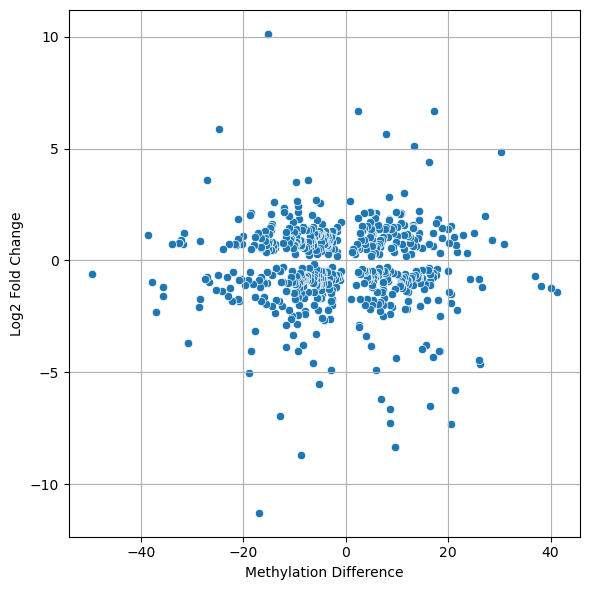

In [7]:
# There isn't any correlation between the methylation difference and the log2 fold change!
plt.figure(figsize=(6, 6))
sns.scatterplot(data=comparison, x='methylation_diff', y='log2fc')
plt.xlabel('Methylation Difference')
plt.ylabel('Log2 Fold Change')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Get some metadata about study OSD-48.
study = "OSD-48"

query = """
MATCH (m:Mission)-->(s:Study)
WHERE s.identifier = $study
RETURN s.identifier AS study, s.project_title AS title, m.name AS mission, 
       m.flight_program AS progam, m.start_date AS start_date, m.end_date AS end_date;
"""
graph.run(query, study=study).to_data_frame()

,study,title,mission,progam,start_date,end_date
0,OSD-48,Rodent Research 1,SpaceX-4,International Space Station (ISS),2014-09-21,2014-10-25
